In [1]:
import numpy as np
from sklearn.decomposition import PCA
from skimage import io
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from motionblur.motionblur import Kernel
import random
import cv2,os
import imageio
from PIL import Image, ImageDraw, ImageFont
import torch
from torchvision import transforms

pca_component = np.load('pca_4096x4096.npy')[:2500]

/home/joowan/anaconda3/envs/blindDPS/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import numpy as np

def bilinear_interpolation_coefficients(r, c):

    '''
    A          B
        
                   
    C          D      -> aqA + apB + bqC + bpD
    
    
    '''

    a = 128 - r           # a
    b = r                 # b  
    q = 128 - c           # q
    p = c                 # p

    weight_00 = a * q     # 좌상단                 
    weight_01 = a * p     # 우상단
    weight_10 = b * q     # 좌하단
    weight_11 = b * p     # 우하단

    return weight_00,weight_01,weight_10,weight_11

# Image size
width, height = 128, 128


interpolation_matrix = np.zeros((height, width, 4))


for r in range(height):
    for c in range(width):
        w00, w01, w10, w11 = bilinear_interpolation_coefficients(r, c)

        # Store the coefficients in the matrix
        interpolation_matrix[r, c, 0] = w00
        interpolation_matrix[r, c, 1] = w01
        interpolation_matrix[r, c, 2] = w10
        interpolation_matrix[r, c, 3] = w11
        

interpolation_matrix = interpolation_matrix * (1/128**2)
print(interpolation_matrix.shape)   # 좌상단, 우상단, 좌하단, 우하단
print(interpolation_matrix[0,0,:])


(128, 128, 4)
[1. 0. 0. 0.]


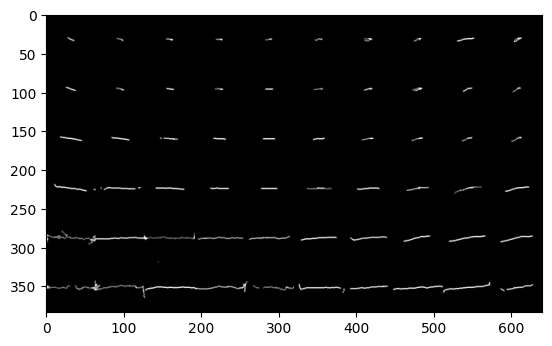

torch.Size([60, 64, 64])
(60, 64, 64)


In [10]:
# 영역 크기 (64, 64)
patch_size = (64, 64)

# 스트라이드 (stride) 크기 (64, 64)
stride = (64, 64)
transform = transforms.ToTensor()
kernel = Image.open('results/NAF/paper/recon/ker_car2.png')
kernel = kernel.convert('L')
plt.imshow(kernel, cmap='gray')
plt.show()

tensor = transform(kernel)
tensor = tensor.unfold(1, patch_size[0], stride[0]).unfold(2,patch_size[1],stride[1]).reshape(1,-1,patch_size[0],patch_size[1]).permute(1,0,2,3).squeeze(1)
tensor = tensor * 255

kernel = np.array(tensor)
print(tensor.shape)
print(kernel.shape)


In [11]:
kernel1 = kernel[0,:,:].reshape(1,-1)
kernel2 = kernel[1,:,:].reshape(1,-1)
kernel3 = kernel[10,:,:].reshape(1,-1)
kernel4 = kernel[11,:,:].reshape(1,-1)

pca_00 = kernel1 @ pca_component.T
pca_01 = kernel2 @ pca_component.T
pca_10 = kernel3 @ pca_component.T
pca_11 = kernel4 @ pca_component.T

pca_list = [pca_00, pca_01, pca_10, pca_11]


In [13]:
kernel1.shape

(1, 4096)

## 커널 하나만 확인

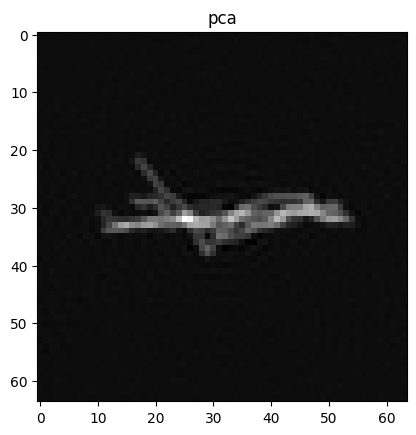

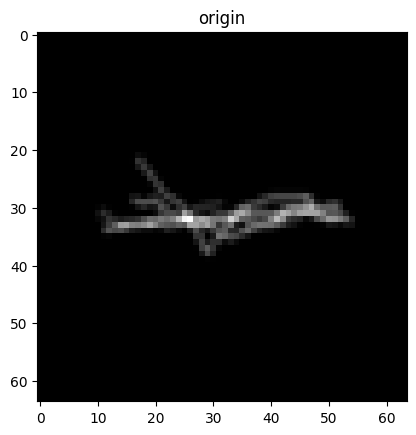

In [8]:
k00 = pca_list[0]
k01 = pca_list[1]
k10 = pca_list[2]
k11 = pca_list[3]

# k00 = kernel1
# k01 = kernel2
# k10 = kernel3
# k11 = kernel4

w00 = interpolation_matrix[64,64,0]
w01 = interpolation_matrix[64,64,1]
w10 = interpolation_matrix[64,64,2]
w11 = interpolation_matrix[64,64,3]

c = k00*w00 + k01*w01 + k10*w10 + k11*w11
c = c @ pca_component

max_value, min_value = np.max(c), np.min(c)
c = 255 * (c - min_value) / (max_value - min_value)
c = c.reshape(64,64)
plt.imshow(c, cmap='gray')
plt.title('pca')
plt.show()


# k00 = pca_list[0]
# k01 = pca_list[1]
# k10 = pca_list[2]
# k11 = pca_list[3]

k00 = kernel1
k01 = kernel2
k10 = kernel3
k11 = kernel4

w00 = interpolation_matrix[64,64,0]
w01 = interpolation_matrix[64,64,1]
w10 = interpolation_matrix[64,64,2]
w11 = interpolation_matrix[64,64,3]

c = k00*w00 + k01*w01 + k10*w10 + k11*w11

max_value, min_value = np.max(c), np.min(c)
c = 255 * (c - min_value) / (max_value - min_value)
c = c.reshape(64,64)
plt.imshow(c, cmap='gray')
plt.title('origin')
plt.show()

## kron without pca

(128, 524288)
(128, 128, 4096)
(4096,)


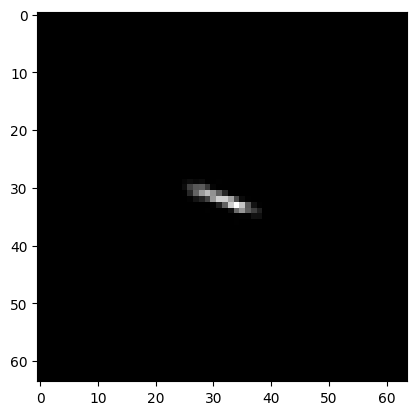

In [12]:
# k00 = pca_list[0]
# k01 = pca_list[1]
# k10 = pca_list[2]
# k11 = pca_list[3]

k00 = kernel1
k01 = kernel2
k10 = kernel3
k11 = kernel4

w00 = interpolation_matrix[:,:,0]
w01 = interpolation_matrix[:,:,1]
w10 = interpolation_matrix[:,:,2]
w11 = interpolation_matrix[:,:,3]

c = np.kron(w00,k00)+np.kron(w01,k01)+np.kron(w10,k10) +np.kron(w11,k11)
print(c.shape)

c = c.reshape(128,128,-1)
print(c.shape)


# k = (c[10,10,:] @ pca_component)
k = c[64,64,:]
print(k.shape)

max_value = np.max(k)
min_value = np.min(k)
k = 255 * (k - min_value) / (max_value - min_value)


k = k.reshape(64,64)
plt.imshow(k,cmap='gray')


# kron with pca

(128, 320000)
(128, 128, 2500)
(128, 128, 4096)
(4096,)


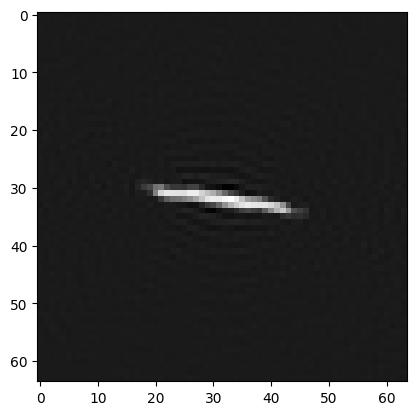

In [67]:
k00 = pca_list[0]
k01 = pca_list[1]
k10 = pca_list[2]
k11 = pca_list[3]

# k00 = kernel1
# k01 = kernel2
# k10 = kernel3
# k11 = kernel4

w00 = interpolation_matrix[:,:,0]
w01 = interpolation_matrix[:,:,1]
w10 = interpolation_matrix[:,:,2]
w11 = interpolation_matrix[:,:,3]

c = np.kron(w00,k00)+np.kron(w01,k01)+np.kron(w10,k10) +np.kron(w11,k11)
print(c.shape)

c = c.reshape(128,128,-1)
print(c.shape)


c = c @ pca_component
print(c.shape)
k = c[100,100,:]
print(k.shape)

max_value = np.max(k)
min_value = np.min(k)
k = 255 * (k - min_value) / (max_value - min_value)


k = k.reshape(64,64)
plt.imshow(k,cmap='gray')
